In [1]:
# mount the google drive root

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

     |████████████████████████████████| 348.9MB 63kB/s 
     |████████████████████████████████| 501kB 46.4MB/s 
     |████████████████████████████████| 3.1MB 39.8MB/s 


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [0]:
# function for loading and downsampling image, max dim as a hyperparam

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float64)
  
  shape = tf.cast(tf.shape(img)[:-1], tf.float64)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
# function for displaying image

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

<class 'tensorflow.python.framework.ops.EagerTensor'>


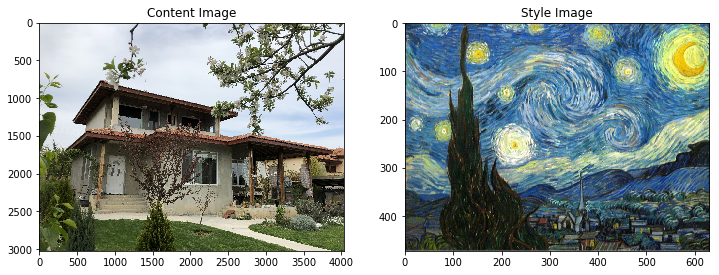

In [11]:
# potentially rotate image - commented out

content_image = load_img('./drive/My Drive/Colab Notebooks/Vision/NST/Content_Style/Content.jpg')
print(type(content_image))
#content_image =   tf.image.rot90(content_image, 3)
style_image = load_img('./drive/My Drive/Colab Notebooks/Vision/NST/Content_Style/image.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [0]:
# calculate color-based clusters for masking images
# we use these masks to crate guides for region-based style transfer

pic_n = tf.reshape(content_image, [content_image.shape[1]*content_image.shape[2], content_image.shape[3]])
pic_s = tf.reshape(style_image, [style_image.shape[1]*style_image.shape[2], style_image.shape[3]])

# number of clusters as hyperparameter, with each image having its own clusters

from sklearn.cluster import KMeans
color_clusters = 2
kmeans = KMeans(n_clusters = color_clusters).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

kmeans_style = KMeans(n_clusters = color_clusters).fit(pic_s)
kmean_style = kmeans_style.cluster_centers_[kmeans_style.labels_]

print(pic2show.shape)
print(kmean_style.shape)

(196608, 3)
(196096, 3)


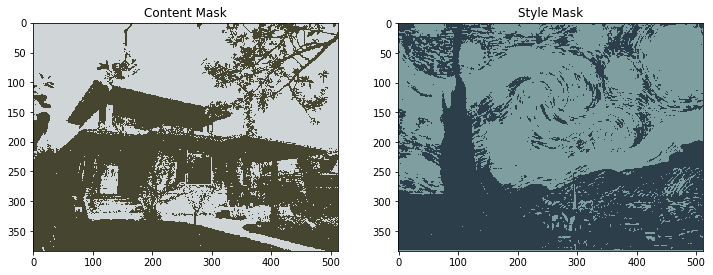

In [0]:
#display pixel-clustered images

cluster_pic = tf.reshape(pic2show, [content_image.shape[1],content_image.shape[2], content_image.shape[3]])
cluster_style = tf.reshape(kmean_style, [style_image.shape[1],style_image.shape[2], style_image.shape[3]])

plt.subplot(1, 2, 1)
imshow(cluster_pic, 'Content Mask')

plt.subplot(1, 2, 2)
imshow(cluster_style, 'Style Mask')

In [0]:
# smooth out the segments/regions of each image, by taking an average of the
# surounding pixels; not ideal...
# the window size used for averaging is a hyperparameter

def Smoothen(input_pic, clusters, window_size = 8):
  input_pic = np.array(input_pic)
  new_pic = input_pic.copy()
  for height in range(input_pic.shape[0]):
    for width in range(input_pic.shape[1]):
      pixel_cluster = np.mean(
          input_pic[max(height - window_size, 0):min(height + window_size, input_pic.shape[0]),
                    max(width - window_size, 0):min(width + window_size, input_pic.shape[1]), 0]
      )
      similarities = []
      for array in clusters:
        similarity = abs(pixel_cluster - array[0])
        similarities.append(similarity)
      region_index = np.argmin(similarities)
      new_pic[height, width,:] = clusters[region_index]
  return new_pic

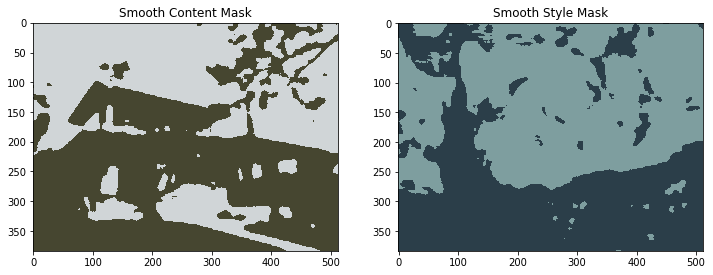

In [0]:
smooth_content = Smoothen(cluster_pic, kmeans.cluster_centers_, 5)
smooth_style = Smoothen(cluster_style, kmeans_style.cluster_centers_, 5)

# display smoothed masks

plt.subplot(1, 2, 1)
imshow(smooth_content, 'Smooth Content Mask')

plt.subplot(1, 2, 2)
imshow(smooth_style, 'Smooth Style Mask')

In [0]:
# encode labels instead of color channel values
# order encodes row > column-wise order for masked regions
# i.e. [0, 1] means that the first pixel should be labeled as 0
# if it is of the first cluster, and vice-versa.. this is needed to ensure
# that the we transfer styles between the specific regions we choose

# comment out the elif/s for fewer clusters and change index of 'order'...

def Label_Encoder(input_pic, clusters, order):
  new_pic = np.zeros((input_pic.shape[0], input_pic.shape[1]))
  for height in range(input_pic.shape[0]):
    for width in range(input_pic.shape[1]):
      if input_pic[height,width,0] == clusters[0][0]:
        new_pic[height,width] = order[0]
#      elif input_pic[height,width,0] == clusters[1][0]:
#        new_pic[height,width] = order[1]
      else:
        new_pic[height,width] = order[1]
  print(new_pic.shape)
  new_data = tf.reshape(new_pic, [new_pic.shape[0]*new_pic.shape[1]])
  return new_data

In [0]:
# label encode images; check if pixels are labeled correctly, as clusters
# are initiated randomly
# change order for more regions...

content_enc = Label_Encoder(smooth_content, kmeans.cluster_centers_, [0,1])
style_enc = Label_Encoder(smooth_style, kmeans_style.cluster_centers_, [0,1])
print(content_enc)
print(style_enc)

(384, 512)
(383, 512)
tf.Tensor([0. 0. 0. ... 1. 1. 1.], shape=(196608,), dtype=float64)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(196096,), dtype=float64)


In [0]:
# one-hot encode the labels to enable guidance of gram matrices by
# matrix multiplication with OHE dimension (3) - multiplying by 1 (transfering style)
# when regions match, and multiplying by 0 when regions don't match
# i.e., the length of dimension (3) corresponds to the number of regions/clusters

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False, categories='auto')
enc.fit(tf.reshape(content_enc, (-1, 1)))
content_guides = enc.transform(tf.reshape(content_enc, (-1, 1)))
style_guides = enc.transform(tf.reshape(style_enc, (-1, 1)))

content_guides = tf.reshape(content_guides, [content_image.shape[1], content_image.shape[2], color_clusters])
content_guides = content_guides[tf.newaxis, :]

style_guides = tf.reshape(style_guides, [style_image.shape[1], style_image.shape[2], color_clusters])
style_guides = style_guides[tf.newaxis, :]

print(content_guides.shape)
print(style_guides.shape)

(1, 384, 512, 2)
(1, 383, 512, 2)


In [0]:
# downsample OHE guides to each convolutional layer's size... not ideal...

content_guide_2 = tf.compat.v2.image.resize(content_guides, [int(content_guides.shape[1]/2), int(content_guides.shape[2]/2)], method = 'nearest')
content_guide_3 = tf.compat.v2.image.resize(content_guides, [int(content_guides.shape[1]/4), int(content_guides.shape[2]/4)], method = 'nearest')
content_guide_4 = tf.compat.v2.image.resize(content_guides, [int(content_guides.shape[1]/8), int(content_guides.shape[2]/8)], method = 'nearest')
content_guide_5 = tf.compat.v2.image.resize(content_guides, [int(content_guides.shape[1]/16), int(content_guides.shape[2]/16)], method = 'nearest')

style_guide_2 = tf.compat.v2.image.resize(style_guides, [int(style_guides.shape[1]/2), int(style_guides.shape[2]/2)], method = 'nearest')
style_guide_3 = tf.compat.v2.image.resize(style_guides, [int(style_guides.shape[1]/4), int(style_guides.shape[2]/4)], method = 'nearest')
style_guide_4 = tf.compat.v2.image.resize(style_guides, [int(style_guides.shape[1]/8), int(style_guides.shape[2]/8)], method = 'nearest')
style_guide_5 = tf.compat.v2.image.resize(style_guides, [int(style_guides.shape[1]/16), int(style_guides.shape[2]/16)], method = 'nearest')

print(content_guide_5.shape)
print(style_guide_5.shape)

(1, 24, 32, 2)
(1, 23, 32, 2)


In [0]:
# load pre-trained CNN model

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 8s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer where will pull our content map to calculate loss
content_layers = [('block5_conv2', 1)] 

# Style layers of interest, plus respective weight and guides for each image
# each weight is a hyperparameter
style_layers = [('block1_conv1', 0.5, content_guides, style_guides),
                ('block2_conv1', 0.5, content_guide_2, style_guide_2),
                ('block3_conv1', 0.5, content_guide_3, style_guide_3),
                ('block4_conv1', 0.5, content_guide_4, style_guide_4),
                ('block5_conv1', 0.5, content_guide_5, style_guide_5)]

empty_layers = np.array(list(layer[1] for layer in style_layers))
non_empty = np.count_nonzero(empty_layers)
num_content_layers = len(content_layers)
num_style_layers = non_empty

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [0]:
style_extractor = vgg_layers(list(layer[0] for layer in style_layers))
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output; layer weights impact this
for name, output in zip(list(layer[0] for layer in style_layers), style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 383, 512, 64)
  min:  0.0
  max:  835.7418
  mean:  24.594976

block2_conv1
  shape:  (1, 191, 256, 128)
  min:  0.0
  max:  2823.495
  mean:  146.98404

block3_conv1
  shape:  (1, 95, 128, 256)
  min:  0.0
  max:  8314.28
  mean:  145.87523

block4_conv1
  shape:  (1, 47, 64, 512)
  min:  0.0
  max:  18004.186
  mean:  553.5738

block5_conv1
  shape:  (1, 23, 32, 512)
  min:  0.0
  max:  3642.1023
  mean:  45.969654



In [0]:
# should return concatenated gram matrices for each region, on axis 1?
# each region has weight, in zip
# for each feature map, we duplicate the guide, and multiply the tensor to get
# the guided feature maps from which we get the guided gram matrices
# i.e. only pixels whose guide is 1 (from the OHE)
# will contribute to the gram matrix for the respective region

# assign weights manually?

region_weights = []
for i in range(color_clusters):
  region_weights.append(1)


def gram_matrix(input_tensor, guide):
  gram_matrices = []
  
  for l, weight in zip(range(color_clusters), region_weights):
  
    feature_maps = tf.shape(input_tensor)[3]
    guides = tf.compat.v1.to_float(guide[:,:,:,l])
    tensor_list = []

    for i in range(feature_maps):
      tensor_list.append(guides)

    conc_guide = tf.stack(tensor_list, axis = 3)

    guided_tensor = tf.multiply(input_tensor, conc_guide)

    result = tf.multiply(tf.linalg.einsum('bijc,bijd->bcd', guided_tensor, guided_tensor), weight)
    num_locations = tf.math.reduce_sum(guides)
    gram_matrix = result / (num_locations)
    gram_matrices.append(gram_matrix)
  
  gram_matrices = tf.concat(gram_matrices, axis = 1)
  return gram_matrices

In [0]:
# calculate the style and content losses, with separate style outputs for the 
# target, content and style images in order to easily feed the respective guides
# i.e. - content guide for the 'new' image, style guide for the 'tar' (style target)
# image, and a pass for the content image (which is only needed for the content loss)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, img):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(list(layer[0] for layer in style_layers) + list(layer[0] for layer in content_layers))
    self.style_layers = list(layer[0] for layer in style_layers)
    self.content_layers = list(layer[0] for layer in style_layers)
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    self.img = img

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    if self.img == 'tar':
      style_outputs = [gram_matrix(style_output, style_guide) * weight
                       for weight, style_guide, style_output in zip(list(layer[1] for layer in style_layers),
                                                                    list(layer[3] for layer in style_layers),
                                                                    style_outputs)]
    elif self.img == 'con':
      pass
    
    else:
      style_outputs = [gram_matrix(style_output, content_guide) * weight
                       for weight, content_guide, style_output in zip(list(layer[1] for layer in style_layers),
                                                                      list(layer[2] for layer in style_layers),
                                                                      style_outputs)]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
# extract the targets and set up the extractor for the iterative process ('new')

target_extractor = StyleContentModel(style_layers, content_layers, img = 'tar')

content_target_extractor = StyleContentModel(style_layers, content_layers, img = 'con')

extractor = StyleContentModel(style_layers, content_layers, img = 'new')

results = target_extractor(tf.constant(style_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

W0722 07:44:58.978712 140491231909760 deprecation.py:323] From <ipython-input-23-66c5846086d3>:13: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Styles:
   block1_conv1
    shape:  (1, 128, 64)
    min:  0.0013760692
    max:  13133.837
    mean:  346.67734

   block2_conv1
    shape:  (1, 256, 128)
    min:  0.0
    max:  91357.29
    mean:  9199.212

   block3_conv1
    shape:  (1, 512, 256)
    min:  0.0
    max:  269259.62
    mean:  9092.823

   block4_conv1
    shape:  (1, 1024, 512)
    min:  0.0
    max:  4688800.5
    mean:  114623.7

   block5_conv1
    shape:  (1, 1024, 512)
    min:  0.0
    max:  67864.625
    mean:  770.6403

Contents:
   block1_conv1
    shape:  (1, 23, 32, 512)
    min:  0.0
    max:  1446.984
    mean:  14.573182


In [0]:
# define the targets

style_targets = target_extractor(style_image)['style']
content_targets = content_target_extractor(content_image)['content']

In [0]:
# create the new image

image = tf.Variable(content_image)

In [0]:
# clip for high-pass filter... more hyperparameters...

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
# more hyperparameters...

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
# yet more hyperparameters...

style_weight=1e2
content_weight=1e3

In [0]:
# apply gatys' loss function (non-commented); commented out is old one
# denominators could be treated as a hyperparameter?

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.reduce_sum([(1/(4 * (style_outputs[name].shape[2] ** 2)))*tf.reduce_sum(tf.square(tf.subtract(style_outputs[name], style_targets[name])))
                               for name in style_outputs.keys()])
#    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
#                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = tf.cast(style_loss, tf.float32) + tf.cast(content_loss, tf.float32)
    return loss

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [0]:
# not sure what the impact of this is...

total_variation_weight=1e8

In [0]:
# gradient tape function for eager Tensorflow execution (non-graph/session)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
image = tf.Variable(content_image)

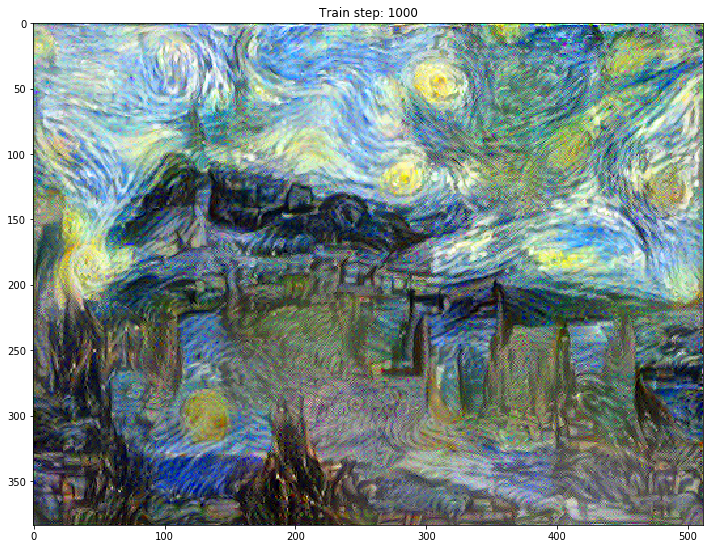

Total time: 1778.2


In [0]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

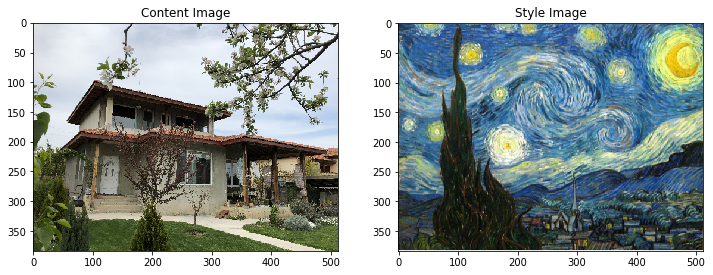

In [0]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [0]:
# download generated image

from PIL import Image

import matplotlib
file_name = 'cloud.png'
matplotlib.image.imsave(file_name, image[0])

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)

(1, 1125, 1500, 3)


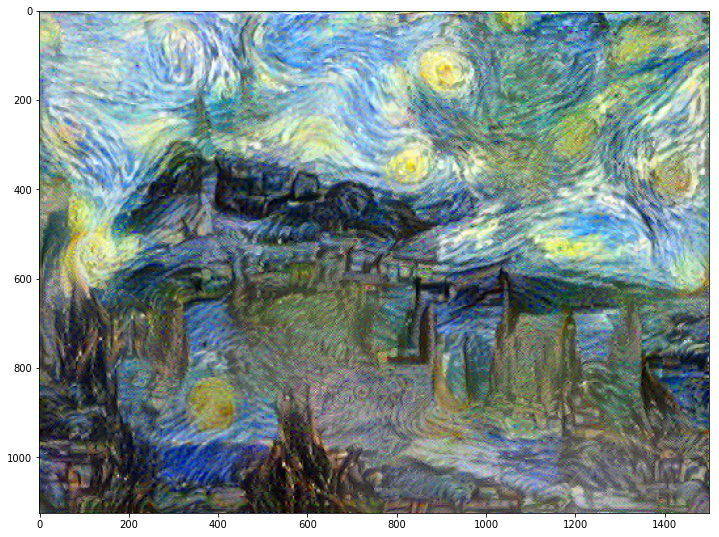

In [0]:
# upscale the image to prepare for further stylisation on lower level

#new_image = tf.io.read_file('/content/drive/My Drive/Colab Notebooks/CNN/NST/Content_Style/Content.jpg')
new_image = image[0]
up_dim = 1500
#new_image = tf.image.decode_image(new_image, channels=3)
new_image = tf.image.convert_image_dtype(new_image, tf.float64)

new_shape = tf.cast(tf.shape(new_image)[:-1], tf.float64)
max_dim = max(new_shape)
up_scale = up_dim / max_dim
up_shape = tf.cast(new_shape * up_scale, tf.int32)
upped_image = tf.image.resize(new_image, up_shape)
upped_image = upped_image[tf.newaxis, :]

print(upped_image.shape)
imshow(upped_image)
plt.show()

In [0]:
# download generated image

from PIL import Image

import matplotlib
file_name = 'cloud.png'
matplotlib.image.imsave(file_name, upped_image)

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)